In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from scipy import ndimage

%matplotlib widget

from jfunctions import *

In [2]:
# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

#Load simulation data
b, phi, w, times = load_data('th1_xz', 'th2_xz', 'w_xz')
NSAMP = len(times)

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

times, t0_idx = calibrate_time(save_dir, times)

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Plume penetration occured at t=2.6169


In [3]:
print(md)

{'LX': 1.0, 'LY': 1.0, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 50.0, 'VERSION': 3.12, 'NU_START_TIME': 10.0, 'SAVE_STATS_DT_FINE': 0.02, 'FINE_RES_TIME': 1.0, 'TIME_LIMIT': 23.0, 'NBUOY_PERIODS': 3.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 512, 'Ny': 512, 'Nz': 257, 'Nth': 2}


In [4]:
#Create grid
X, Y = np.meshgrid(gx, gz)
Xf, Yf = np.meshgrid(gxf, gzf)

# Time control
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per
tend_idx = len(times)-1
tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 156
Dimensional times:  [-2.61686932 -1.04186932  0.          1.575       3.15        4.725
  6.3         6.426       6.552       6.678       6.804       6.93
  7.056       7.182       7.308       7.434       7.56        7.686
  7.812       7.938       8.064       8.19        8.316       8.442
  8.568       8.694       8.82        8.946       9.072       9.198
  9.324       9.45        9.576       9.702       9.828       9.954
 10.08       10.206      10.332      10.458      10.584      10.71
 10.836      10.962      11.088      11.214      11.34       11.466
 11.592      11.718      11.844      11.97       12.096      12.222
 12.348      12.474      12.6        12.726      12.852      12.978
 13.104      13.23       13.356      13.482      13.608      13.734
 13.86       13.986      14.112      14.238      14.364      14.49
 14.616      14.742      14.868      14.994      15.12       15.246
 15.372      15.498      15.624      15.75       15.876      16.002
 16.128  

In [5]:
tracer_thresh = 1e-3

tracer_data_full = np.where(phi >= tracer_thresh, phi, 0)
plume_full = np.where(tracer_data_full >= tracer_thresh, 1, 0)

heights = []
for i in range(len(plume_full)):
    stuff = np.where(plume_full[i] == 1)[0]
    if len(stuff) == 0:
        heights.append(0)
    else:
        heights.append(gzf[np.max(stuff)+1])

[ 6.3    6.426  6.552  6.678  6.804  6.93   7.056  7.182  7.308  7.434
  7.56   7.686  7.812  7.938  8.064  8.19   8.316  8.442  8.568  8.694
  8.82   8.946  9.072  9.198  9.324  9.45   9.576  9.702  9.828  9.954
 10.08  10.206 10.332 10.458 10.584 10.71  10.836 10.962 11.088 11.214
 11.34  11.466 11.592 11.718 11.844 11.97  12.096 12.222 12.348 12.474
 12.6   12.726 12.852 12.978 13.104 13.23  13.356 13.482 13.608 13.734
 13.86  13.986 14.112 14.238 14.364 14.49  14.616 14.742 14.868 14.994
 15.12  15.246 15.372 15.498 15.624 15.75  15.876 16.002 16.128 16.254
 16.38  16.506 16.632 16.758 16.884 17.01  17.136 17.262 17.388 17.514
 17.64  17.766 17.892 18.018 18.144 18.27  18.396 18.522 18.648 18.774
 18.9   19.026 19.152 19.278 19.404 19.53  19.656 19.782 19.908 20.034
 20.16  20.286 20.412 20.538 20.664 20.79  20.916 21.042 21.168 21.294
 21.42  21.546 21.672 21.798 21.924 22.05  22.176 22.302 22.428 22.554
 22.68  22.806 22.932 23.058 23.184 23.31  23.436 23.562 23.688 23.814
 23.94

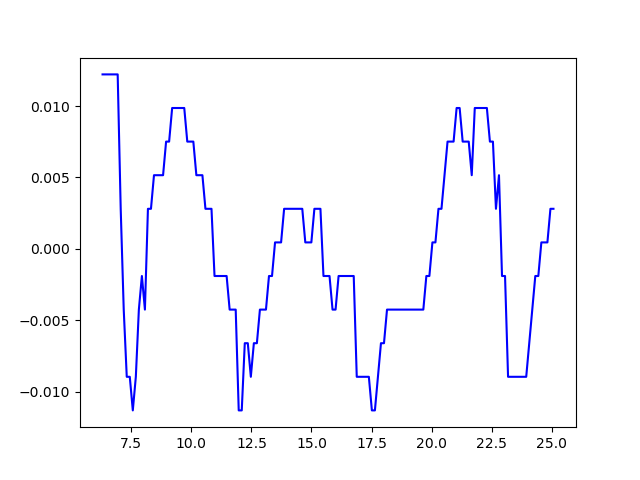

In [6]:
fig = plt.figure()

times = times[tstart_idx:]
print(times)
heights = heights[tstart_idx:]
heights -= np.mean(heights)
plt.plot(times, heights, color='b')

In [7]:
freq_spectrum = np.fft.rfft(heights)
freq = np.fft.rfftfreq(len(heights)) * 2*np.pi/md['SAVE_STATS_DT_FINE']

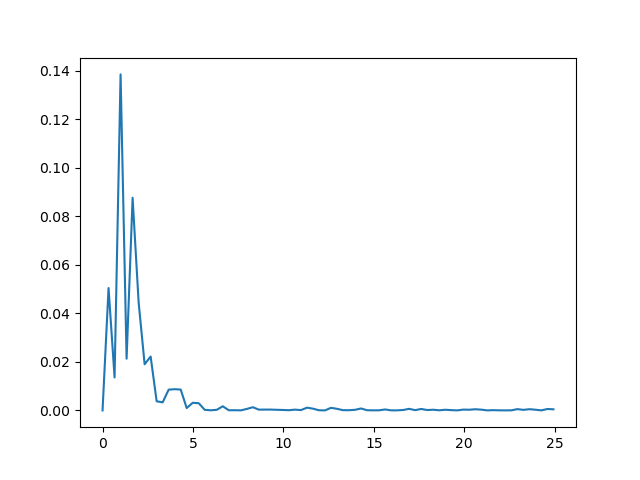

In [8]:
fig2 = plt.figure()
plt.plot(freq, np.power(np.abs(freq_spectrum), 2))

In [9]:
##### Calculate characteristic frequency #####
omega_c = 0
norm = 0
N = np.sqrt(md['N2'])
amp2 = np.power(np.abs(freq_spectrum), 2)

for i in range(np.where(freq <= 5)[0][-1]):
    norm += amp2[i]
    omega_c += freq[i]*amp2[i]

omega_c /= norm
print(omega_c,omega_c/N)

1.5310837243095599 1.5310837243095599
